In [2]:
%pylab inline
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
from scipy.stats import ttest_rel
import copy
import pickle
import pandas as pd
import copy

import numpy as np
from numpy import linalg as LA
import scipy
from scipy.sparse import csr_matrix
from sklearn import preprocessing

from gensim.models import Word2Vec
from gensim import utils
from gensim.corpora import Dictionary
from gensim.models.lsimodel import LsiModel

from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


from sklearn.decomposition import PCA

In [4]:
we_model_name = "sg_dim300_min200_win5"
#we_model_name = "sg_dim300_max50k_win5"
we_vector_size = 300
manipluated_list = ['orig', 'swapped#0.5', 'swapped#1.0']

we_model_dirs = {}
we_model_dirs['orig'] = "/data/text/retrieval/wordembeddings/word2vecgensim/wikipedia/wiki-english-20171001/%s" % we_model_name
for x in manipluated_list[1:]:
    we_model_dirs[x] = "/data/text/retrieval/wordembeddings/word2vecgensim/wikipedia/wiki-english-20171001/manipulated-swapped/%s/%s" % (we_model_name, x)




In [5]:
we_models = {}

for x in manipluated_list:
    print (x)
    we_models[x] = Word2Vec.load(we_model_dirs[x]+'/model.gensim')

print ('loading done!')

orig
swapped#0.5
swapped#1.0
loading done!


In [6]:
#power=0.75

#we_vocab_count = []
#for _wrd in we_models['orig'].wv.index2word:
#    we_vocab_count.append(we_models['orig'].wv.vocab[_wrd].count)
#we_vocab_count = np.array(we_vocab_count)
#we_vocab_count_downsampled = we_vocab_count**power

In [7]:
#loading E_ctx_vec
E_ctx_vec = {}
E_wrd_vec = {}
for _manip in manipluated_list:
    print (_manip)
    with open(we_model_dirs[_manip]+'/E_ctx_vec.pkl', 'rb') as fr:
        E_ctx_vec[_manip] = pickle.load(fr)
    with open(we_model_dirs[_manip]+'/E_wrd_vec.pkl', 'rb') as fr:
        E_wrd_vec[_manip] = pickle.load(fr)

orig
swapped#0.5
swapped#1.0


In [111]:
#def get_explicit_vecs(we_model, words):
#    eSG_vecs = {}
#    for word in words:
#        _idx = we_model.wv.vocab[word].index
#        _vec = we_model.wv.vectors[_idx]
#        # explicit SkipGram
#        eSG_vecs[word] = scipy.special.expit(np.dot(we_model.trainables.syn1neg, _vec))
#    return eSG_vecs

def get_explicit_vecs(_manip, words):
    _we_model = we_models[_manip]
    _E_ctx_vec = E_ctx_vec[_manip]
    _E_wrd_vec = E_wrd_vec[_manip]
    
    eSG_vecs = {}
    for word in words:
        _idx = _we_model.wv.vocab[word].index
        _vec = _we_model.wv.vectors[_idx]
        
        # explicit SkipGram
        eSG_vecs[word] = scipy.special.expit(np.dot(_we_model.trainables.syn1neg, _vec))
        eSG_vecs[word] /= np.sqrt(_E_ctx_vec * _E_wrd_vec[_idx])
    
    return eSG_vecs

get_explicit_vecs('orig', ['book'])


{'book': array([0.20952858, 0.5842162 , 0.6536103 , ..., 0.13579279, 0.13832629,
        0.1703568 ], dtype=float32)}

In [112]:
def Cosine(vec1, vec2):
    return 1 - scipy.spatial.distance.cosine(vec1, vec2)

def NegDifNorm(vec1, vec2):
    return -np.linalg.norm((vec1/np.linalg.norm(vec1)) - (vec2/np.linalg.norm(vec2)))

def get_explicit_vecs_similarity(_manip, word_from, words_to):
    eSG_vecs_from = get_explicit_vecs(_manip, [word_from])
    eSG_vecs_to = get_explicit_vecs(_manip, words_to)
    
    sims_eSG={}
    for word_to in words_to:
        if word_to in we_models[_manip].wv.vocab:
            sims_eSG[word_to] = Cosine(eSG_vecs_from[word_from], eSG_vecs_to[word_to])
    
    return sims_eSG

get_explicit_vecs_similarity('orig', 'book', ['book', 'library'])

{'book': 1.0, 'library': 0.5434122681617737}

In [113]:
for x in manipluated_list:
    print (x, len(we_models[x].wv.vocab))
    

orig 197549
swapped#0.5 215364
swapped#1.0 231864


## Gender Biasing Quantification

In [114]:
job_eSG_vecs = {}
job_tuples = {}
for _manip in manipluated_list:
    job_tuples[_manip]=[]
    with open('resources/wordlist_occupations.txt') as fr:
        for l in fr:
            _tuple=l.strip('\n').split(',')
            if _tuple[0] in we_models[_manip].wv.vocab:
                job_tuples[_manip].append(_tuple)
    print (len(job_tuples[_manip]))

    print (_manip)
    job_eSG_vecs[_manip] = get_explicit_vecs(_manip, [x[0] for x in job_tuples[_manip]])




504
orig
505
swapped#0.5
508
swapped#1.0


In [115]:
for _manip in manipluated_list:
    _lst=[x[0] for x in job_tuples[_manip] if x[1]=='f']
    _lst.sort()
    #', '.join(_lst)
    print (_manip, len(_lst))

orig 20
swapped#0.5 20
swapped#1.0 21


In [116]:
genderword_tuples = {}
for _manip in manipluated_list:
    genderword_tuples[_manip] = []

    with open('resources/wordlist_genderspecific_medium.txt') as fr:
        for l in fr:
            _tuple=l.strip('\n').split(',')
            if _tuple[0] in we_models[_manip].wv.vocab:
                _idx = we_models[_manip].wv.vocab[_tuple[0]].index
                genderword_tuples[_manip].append((_tuple[0], _tuple[1], _idx))
            else:
                print (_tuple[0])
    print (_manip, len(genderword_tuples[_manip]))


orig 64
swapped#0.5 64
swapped#1.0 64


In [117]:
fem_SG_vecs = {}
masc_SG_vecs = {}

for _manip in manipluated_list:
    print (_manip)

    _SG_fem_vectors = []
    _SG_masc_vectors = []
    for _tuple in genderword_tuples[_manip]:
        if _tuple[1] == 'f':
            _SG_fem_vectors.append(we_models[_manip].wv.vectors[we_models[_manip].wv.vocab[_tuple[0]].index])
        elif _tuple[1] == 'm':
            _SG_masc_vectors.append(we_models[_manip].wv.vectors[we_models[_manip].wv.vocab[_tuple[0]].index])

    fem_SG_vecs[_manip] = np.mean(np.array(_SG_fem_vectors), axis=0)
    masc_SG_vecs[_manip] = np.mean(np.array(_SG_masc_vectors), axis=0)



orig
swapped#0.5
swapped#1.0


In [118]:
fem_exp_feature_vecs = {}
masc_exp_feature_vecs = {}

for _manip in manipluated_list:
    print (_manip)

    fem_exp_feature_vecs[_manip] = np.zeros(len(we_models[_manip].wv.vocab))
    masc_exp_feature_vecs[_manip] = np.zeros(len(we_models[_manip].wv.vocab))
    for _tuple in genderword_tuples[_manip]:
        if _tuple[1] == 'f':
            fem_exp_feature_vecs[_manip][_tuple[2]] = 1
        elif _tuple[1] == 'm':
            masc_exp_feature_vecs[_manip][_tuple[2]] = 1


orig
swapped#0.5
swapped#1.0


In [119]:
for _manip in manipluated_list:
    print (_manip)
    print (len([x for x in genderword_tuples[_manip] if x[1]=='f']), len([x for x in genderword_tuples[_manip] if x[1]=='m']))

orig
32 32
swapped#0.5
32 32
swapped#1.0
32 32


### calculating bias

In [120]:
job_eSG_biases = {}
for _manip in manipluated_list:
    job_eSG_biases[_manip] = []
    for job_tuple in job_tuples[_manip]:
        _vec = job_eSG_vecs[_manip][job_tuple[0]]
        job_eSG_biases[_manip].append((job_tuple[0], 
                                  np.dot(_vec, fem_exp_feature_vecs[_manip]) - np.dot(_vec, masc_exp_feature_vecs[_manip]),
                                  np.dot(_vec, fem_exp_feature_vecs[_manip]), 
                                  np.dot(_vec, masc_exp_feature_vecs[_manip]), job_tuple[1]))

    job_eSG_biases[_manip].sort(key=lambda x: x[1])


In [121]:
job_SG_femmasc_cosine_biases = {}
for _manip in manipluated_list:
    job_SG_femmasc_cosine_biases[_manip] = []
    for job_tuple in job_tuples[_manip]:
        _vec = we_models[_manip].wv.vectors[we_models[_manip].wv.vocab[job_tuple[0]].index]
        job_SG_femmasc_cosine_biases[_manip].append((job_tuple[0], 
                                                Cosine(_vec, fem_SG_vecs[_manip]) - Cosine(_vec, masc_SG_vecs[_manip]),
                                                Cosine(_vec, fem_SG_vecs[_manip]), 
                                                Cosine(_vec, masc_SG_vecs[_manip]), job_tuple[1]))

    job_SG_femmasc_cosine_biases[_manip].sort(key=lambda x: x[1])
    

In [124]:
# bias values for all words
allwords_eSG_bias={}
allwords_SG_cosine_bias={}
for _manip in manipluated_list:
    
    #if _manip=='orig':
    #    _folder = "data"
    #else:
    #    _folder = "data/manipulated-"+'swapped#1.0'#_manip
    _folder = "data"
    
    
    _path = os.path.join(_folder, "allwords_recSGnormsqrt_bias.pkl")
    #_path = os.path.join(_folder, "allwords_recSGnorm_bias.pkl")
    #_path = os.path.join(_folder, "allwords_eSG_bias.pkl")
    print ('loading %s' % _path)
    with open(_path, 'rb') as fw:
        allwords_eSG_bias[_manip] = pickle.load(fw)

    _path = os.path.join(_folder, "allwords_dense_cosine_bias.pkl")
    print ('loading %s' % _path)
    with open(_path, 'rb') as fw:
        allwords_SG_cosine_bias[_manip] = pickle.load(fw)



loading data/allwords_recSGnormsqrt_bias.pkl
loading data/allwords_dense_cosine_bias.pkl
loading data/allwords_recSGnormsqrt_bias.pkl
loading data/allwords_dense_cosine_bias.pkl
loading data/allwords_recSGnormsqrt_bias.pkl
loading data/allwords_dense_cosine_bias.pkl


In [125]:
#### neutral borders
eSG_bias_expectation_fem = {}
eSG_bias_expectation_mas = {}
SG_cosine_bias_expectation_fem = {}
SG_cosine_bias_expectation_mas = {}

for _manip in manipluated_list:
    eSG_bias_expectation_fem[_manip] = np.average([np.abs(x[0]-x[1]) for x in allwords_eSG_bias[_manip]])#, weights=we_vocab_count_downsampled
    eSG_bias_expectation_mas[_manip] = np.average([np.abs(x[0]-x[1]) for x in allwords_eSG_bias[_manip]])#, weights=we_vocab_count_downsampled
    print ('eSG_bias_expectation '+_manip, eSG_bias_expectation_fem[_manip], eSG_bias_expectation_mas[_manip])

    SG_cosine_bias_expectation_fem[_manip] = np.average([np.abs(x[0]-x[1]) for x in allwords_SG_cosine_bias[_manip]])
    SG_cosine_bias_expectation_mas[_manip] = np.average([np.abs(x[0]-x[1]) for x in allwords_SG_cosine_bias[_manip]])#, weights=we_vocab_count_downsampled
    print ('SG_bias_expectation '+_manip, SG_cosine_bias_expectation_fem[_manip], SG_cosine_bias_expectation_mas[_manip])




eSG_bias_expectation orig 11.617065675480283 11.617065675480283
SG_bias_expectation orig 0.03614112234746913 0.03614112234746913
eSG_bias_expectation swapped#0.5 11.617065675480283 11.617065675480283
SG_bias_expectation swapped#0.5 0.03614112234746913 0.03614112234746913
eSG_bias_expectation swapped#1.0 11.617065675480283 11.617065675480283
SG_bias_expectation swapped#1.0 0.03614112234746913 0.03614112234746913


In [126]:
## scale to MinMax

from sklearn.preprocessing import MinMaxScaler


job_eSG_biases_scaled = {}
eSG_bias_expectation_fem_scaled = {}
eSG_bias_expectation_mas_scaled = {}

for _manip in manipluated_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array([x[0] for x in allwords_eSG_bias['orig']]+[x[1] for x in allwords_eSG_bias['orig']]+[0]).reshape(-1, 1))
    #scaler.fit(np.array([x[0]-x[1] for x in allwords_eSG_bias['orig']]).reshape(-1, 1))
    print(_manip, scaler.data_max_)

    job_eSG_biases_scaled[_manip] = []
    for tpl in job_eSG_biases[_manip]:
        tpl2, tpl3 = scaler.transform(np.array([tpl[2],tpl[3]]).reshape(1, -1))[0]
        job_eSG_biases_scaled[_manip].append((tpl[0], tpl2 - tpl3, tpl2, tpl3, tpl[4]))
    eSG_bias_expectation_fem_scaled[_manip], eSG_bias_expectation_mas_scaled[_manip] = scaler.transform(np.array([eSG_bias_expectation_fem[_manip], eSG_bias_expectation_mas[_manip]]).reshape(1, -1))[0]
    print ('eSG_bias_expectation_scaled '+_manip, eSG_bias_expectation_fem_scaled[_manip], eSG_bias_expectation_mas_scaled[_manip])


orig [225.08760536]
eSG_bias_expectation_scaled orig 0.05161130777079559 0.05161130777079559
swapped#0.5 [225.08760536]
eSG_bias_expectation_scaled swapped#0.5 0.05161130777079559 0.05161130777079559
swapped#1.0 [225.08760536]
eSG_bias_expectation_scaled swapped#1.0 0.05161130777079559 0.05161130777079559


In [225]:
manipluated_list

['orig', 'swapped#0.5', 'swapped#1.0']

## Bias Changes

In [328]:
bias_changes = {}
bias_changes_scaled = {}
bias_changes_scaled_relative = {}
bias_changes_female = {}
bias_changes_male = {}

for _manip_i, _manip in enumerate(manipluated_list):
    if _manip=='orig':
        continue
    bias_changes[_manip] = []
    bias_changes_scaled[_manip] = []
    bias_changes_scaled_relative[_manip] = []
    bias_changes_female[_manip] = []
    bias_changes_male[_manip] = []

    #for x_job in ['bookmaker', 'gunsmith', 'repairer', 'roofer', 'farrier', 'toolmaker', 'plasterer', 
    #                     'mechanician', 'stonemason', 'bricklayer', 'manicurist', 'nurse', 'housekeeper', 'beautician',
    #                     'homemaker', 'socialite', 'dressmaker', 'dietitian', 'receptionist', 'dancer']:
    #for x_job in ['manicurist', 'housekeeper', 'beautician', 'nurse', 'homemaker',
    #              'bookmaker', 'gunsmith', 'repairer', 'roofer', 'farrier', 
    #              ]:
    for x_job in ['dancer', 'nurse', 'therapist', 'healer', 'dressmaker',
                  'parliamentarian', 'mechanician', 'repairer', 'cabinetmaker', 'bricklayer', 
                  ]:
#['parliamentarian', 'promoter', 'upholsterer', 'cabinetmaker', 'mechanician']
#['healer', 'therapist', 'paralegal', 'obstetrician', 'manicurist']
#['trainer', 'labourer', 'bricklayer', 'diplomat', 'saxophonist']
#['therapist', 'choreographer', 'stylist', 'nurse', 'dancer']

        bias_changes[_manip].append([x_job,
                             [[x[1] for x in job_eSG_biases['orig'] if x[0] == x_job][0], 
                              [x[1] for x in job_eSG_biases[_manip] if x[0] == x_job][0]],
                             [[x[1] for x in job_SG_femmasc_cosine_biases['orig'] if x[0] == x_job][0],
                              [x[1] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0]]])

        val1 = [x[1] for x in job_eSG_biases_scaled['orig'] if x[0] == x_job][0]
        val2 = [x[1] for x in job_eSG_biases_scaled[_manip] if x[0] == x_job][0]
        val3 = [x[1] for x in job_SG_femmasc_cosine_biases['orig'] if x[0] == x_job][0]
        val4 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0]
        bias_changes_scaled[_manip].append([x_job,
                             [val1, val2], [val3, val4]])

        _manip_before = manipluated_list[_manip_i-1]
        val1 = [x[1] for x in job_eSG_biases_scaled[_manip_before] if x[0] == x_job][0]
        val2 = [x[1] for x in job_eSG_biases_scaled[_manip] if x[0] == x_job][0]
        val3 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip_before] if x[0] == x_job][0]
        val4 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0]
        bias_changes_scaled_relative[_manip].append([x_job,
                             [np.abs((val1-val1)/val1), np.abs((val2-val1)/val1)],
                             [np.abs((val3-val3)/val3), np.abs((val4-val3)/val3)]])


        bias_changes_female[_manip].append((x_job,
                             ([x[2] for x in job_eSG_biases_scaled['orig'] if x[0] == x_job][0], 
                              [x[2] for x in job_eSG_biases_scaled[_manip] if x[0] == x_job][0]),
                             ([x[2] for x in job_SG_femmasc_cosine_biases['orig'] if x[0] == x_job][0],
                              [x[2] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0])))

        bias_changes_male[_manip].append((x_job,
                             ([x[3] for x in job_eSG_biases_scaled['orig'] if x[0] == x_job][0], 
                              [x[3] for x in job_eSG_biases_scaled[_manip] if x[0] == x_job][0]),
                             ([x[3] for x in job_SG_femmasc_cosine_biases['orig'] if x[0] == x_job][0],
                              [x[3] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0])))





In [329]:
bias_changes_scaled_relative

{'swapped#0.5': [['dancer',
   [0.0, 0.7736103542580169],
   [0.0, 0.6143856813641334]],
  ['nurse', [0.0, 0.7146416162989161], [0.0, 0.5690445858225583]],
  ['therapist', [0.0, 0.8342586686297181], [0.0, 0.6604605755603234]],
  ['healer', [0.0, 0.9336273539574993], [0.0, 0.9381880954656563]],
  ['dressmaker', [0.0, 0.6417271765779754], [0.0, 0.4350281286923615]],
  ['parliamentarian', [0.0, 0.861322681838008], [0.0, 0.66052362362207]],
  ['mechanician', [0.0, 0.6088031188254653], [0.0, 0.6498531368007952]],
  ['repairer', [0.0, 0.4869748029444384], [0.0, 0.4510198668653066]],
  ['cabinetmaker', [0.0, 0.691928743488109], [0.0, 0.6361775190527686]],
  ['bricklayer', [0.0, 0.5323442657790505], [0.0, 0.5497471372724494]]],
 'swapped#1.0': [['dancer',
   [0.0, 0.872748284592845],
   [0.0, 0.9423520838111585]],
  ['nurse', [0.0, 0.9994901698061724], [0.0, 1.046711845117882]],
  ['therapist', [0.0, 0.7581666962015926], [0.0, 0.9379974899543395]],
  ['healer', [0.0, 1.6033242794705103], [0.0,

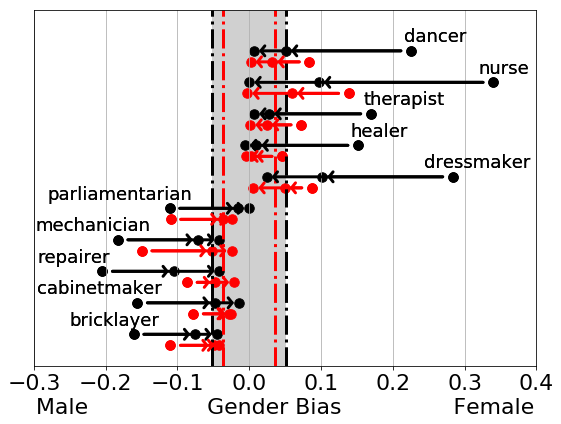

In [371]:

fsize=22
fsize2=18

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_color_unbiasedarea='#bdbdbd'
_color_unbiasedarea2='red'
_color_unbiasedborder='black'#'#737373'
_color_unbiasedborder2='red'
_color_unbiasedpnt='#636363'
_color_SG_male='red'
_color_eSG_male='black'
_color_SG_female='#6baed6'#3182bd
_color_eSG_female='#08519c'


size_cof = 1
min_x = -0.3
max_x = 0.4
max_y=11.3#*size_cof


_bias_expectation_fem = eSG_bias_expectation_fem_scaled['orig']
_bias_expectation_mas = eSG_bias_expectation_mas_scaled['orig']
_bias_expectation_fem2 = SG_cosine_bias_expectation_fem['orig']
_bias_expectation_mas2 = SG_cosine_bias_expectation_mas['orig']


fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))


ax.axvline(x=-_bias_expectation_mas, c=_color_unbiasedborder, ls='-.', lw=3)
ax.axvline(x=+_bias_expectation_fem, c=_color_unbiasedborder, ls='-.', lw=3)
ax.fill_between([-_bias_expectation_mas,_bias_expectation_fem], 
                [0, 0],
                [max_y, max_y],
                facecolor=_color_unbiasedarea, alpha=0.7, interpolate=True)
ax.axvline(x=-_bias_expectation_mas2, c=_color_unbiasedborder2, ls='-.', lw=3)
ax.axvline(x=+_bias_expectation_fem2, c=_color_unbiasedborder2, ls='-.', lw=3)
#ax.fill_between([-_bias_expectation_mas2,_bias_expectation_fem2], 
#                [0, 0],
#                [max_y, max_y],
#                facecolor=_color_unbiasedarea, alpha=0.1, interpolate=True)

for _manip_i, _manip in enumerate(manipluated_list[1:]):

    _bias_changes = bias_changes_scaled[_manip]

    for i in range(0,len(_bias_changes)):
        x=_bias_changes[i][1]
        y=[(10-i)*size_cof, (10-i)*size_cof]
        ax.scatter(x, y, c=_color_eSG_male, s=90, marker='o')
        ax.annotate("", xy=(x[0], y[0]), xytext=(x[1], y[1]),
                    arrowprops={'arrowstyle': '<-, head_width=0.5', 'ls':'-', 'lw':3, 
                                'color': _color_eSG_male, 'shrinkB':10, 'shrinkA':5}
                   )
        _text=_bias_changes[i][0]
        #_text=_text[0].upper()+_text[1:]
        if i==0:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.01, y[0]+0.3), fontsize=fsize2)
        elif i==1:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.02, y[0]+0.3), fontsize=fsize2)
        elif i==2:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.01, y[0]+0.3), fontsize=fsize2)
        elif i==3:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.01, y[0]+0.3), fontsize=fsize2)
        elif i==4:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.04, y[0]+0.3), fontsize=fsize2)
        elif i==5:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.17, y[0]+0.3), fontsize=fsize2)
        elif i==6:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.115, y[0]+0.3), fontsize=fsize2)
        elif i==7:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.09, y[0]+0.3), fontsize=fsize2)
        elif i==8:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.14, y[0]+0.3), fontsize=fsize2)
        elif i==9:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.09, y[0]+0.3), fontsize=fsize2)
        else:
            ax.annotate(_text, xy=(x[0], y[0]), xytext=(x[0]-0.09, y[0]+0.3), fontsize=fsize2)
        
        x=_bias_changes[i][2]
        y=[(10-i-0.35)*size_cof, (10-i-0.35)*size_cof]
        ax.scatter(x, y, c=_color_SG_male, s=90, marker='o')
        ax.annotate("", xy=(x[0], y[0]), xytext=(x[1], y[1]),
                    arrowprops={'arrowstyle': '<-, head_width=0.5', 'ls':'-', 'lw':3, 
                                'color': _color_SG_male, 'shrinkB':10, 'shrinkA':5}
                   )


ax.tick_params(which='major', labelsize=fsize)
ax.set_xlabel('Male                 Gender Bias                Female', fontsize=fsize)
ax.get_yaxis().set_visible(False)
ax.set_xlim(min_x, max_x)
ax.set_ylim(0, max_y)
plt.gca().xaxis.grid(True)

fig.tight_layout()
plt.show()
fig.set_size_inches(8, 6)
fig.savefig('plots/job_recSG_change_swapped.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)





[0.7736103542580169, 0.7146416162989161, 0.8342586686297181, 0.9336273539574993, 0.6417271765779754, 0.861322681838008, 0.6088031188254653, 0.4869748029444384, 0.691928743488109, 0.5323442657790505]
[0.6143856813641334, 0.5690445858225583, 0.6604605755603234, 0.9381880954656563, 0.4350281286923615, 0.66052362362207, 0.6498531368007952, 0.4510198668653066, 0.6361775190527686, 0.5497471372724494]


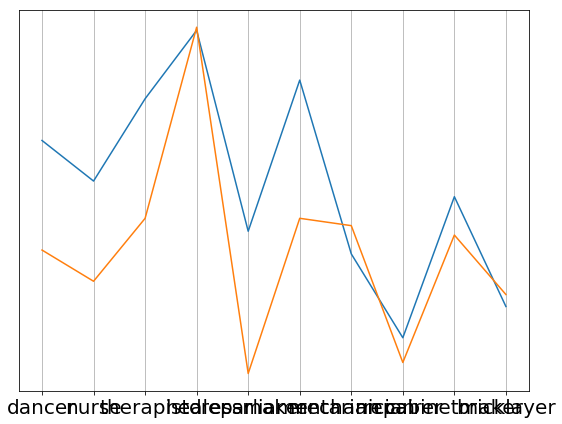

[0.872748284592845, 0.9994901698061724, 0.7581666962015926, 1.6033242794705103, 0.7617889035326608, 0.9792597438446399, 0.4169277975494349, 0.6025068949783156, 0.7039302179647978, 0.3987671588952088]
[0.9423520838111585, 1.046711845117882, 0.9379974899543395, 2.503129534117747, 0.885628672136173, 0.3411229083932177, 0.5294885508742188, 0.5575763907385847, 0.09073073283566396, 0.15587836407679465]


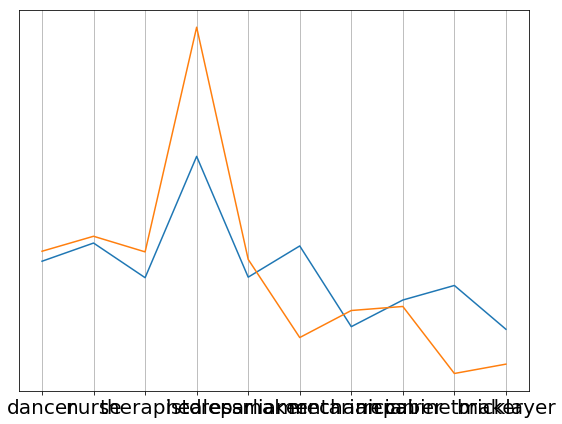

In [337]:

fsize=20
fsize2=18

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_color_unbiasedarea='#bdbdbd'
_color_unbiasedarea2='red'
_color_unbiasedborder='black'#'#737373'
_color_unbiasedborder2='red'
_color_unbiasedpnt='#636363'
_color_SG_male='red'
_color_eSG_male='black'
_color_SG_female='#6baed6'#3182bd
_color_eSG_female='#08519c'


size_cof = 1
min_x = -0.3
max_x = 0.6
max_y=11.3#*size_cof


_bias_expectation_fem = eSG_bias_expectation_fem_scaled['orig']
_bias_expectation_mas = eSG_bias_expectation_mas_scaled['orig']
_bias_expectation_fem2 = SG_cosine_bias_expectation_fem['orig']
_bias_expectation_mas2 = SG_cosine_bias_expectation_mas['orig']



for _manip_i, _manip in enumerate(manipluated_list[1:]):

    fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))


    _bias_changes = bias_changes_scaled_relative[_manip]

    xlist = []
    y1list = []
    y2list = []
    for i in range(0,len(_bias_changes)):
        xlist.append(_bias_changes[i][0])
        
        y1list.append(abs(_bias_changes[i][1][1] - _bias_changes[i][1][0]))
        y2list.append(abs(_bias_changes[i][2][1] - _bias_changes[i][2][0]))

    ax.plot(xlist, y1list)
    ax.plot(xlist, y2list)
    print (y1list)
    print (y2list)

    ax.tick_params(which='major', labelsize=fsize)
    #ax.set_xlabel('Male                    Gender Bias                   Female', fontsize=fsize)
    ax.get_yaxis().set_visible(False)
    #ax.set_xlim(min_x, max_x)
    #ax.set_ylim(0, max_y)
    plt.gca().xaxis.grid(True)

    fig.tight_layout()
    plt.show()
    fig.set_size_inches(8, 6)
    #fig.savefig('plots/job_recSG_change_swapped.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)






swapped#0.5


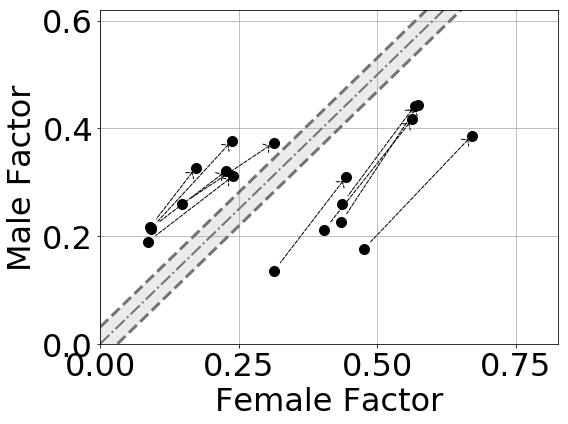

swapped#1.0


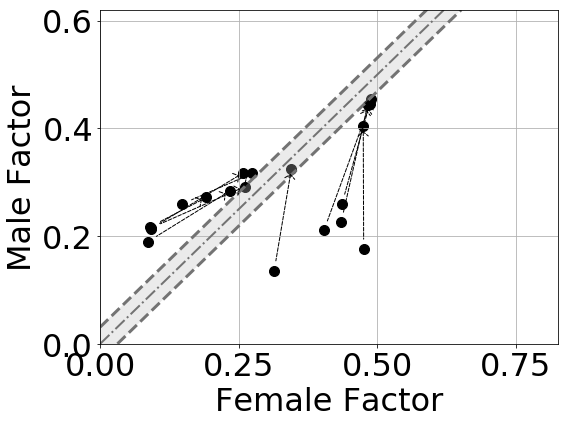

In [36]:

fsize=32
fsize2=18

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']



_color_unbiasedarea='#bdbdbd'
_color_unbiasedborder='#737373'
_color_unbiasedpnt='#636363'
_color_SG_male='red'
_color_eSG_male='black'
_color_SG_female='#6baed6'#3182bd
_color_eSG_female='#08519c'

max_x=0.826
max_y=0.62
size_cof = 1.4

for _manip in manipluated_list:
    if _manip=='orig':
        continue
    print (_manip)
    
    fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))

    _bias_expectation_fem = eSG_bias_expectation_fem_scaled[_manip]
    _bias_expectation_mas = eSG_bias_expectation_mas_scaled[_manip]
    _bias_changes_tuples = list(zip(bias_changes_female[_manip], bias_changes_male[_manip]))


    for i in range(0,len(_bias_changes)):
        x=_bias_changes_tuples[i][0][1]
        y=_bias_changes_tuples[i][1][1]
        ax.scatter(x, y, c=_color_eSG_male, s=100, marker='o')
        #ax.annotate(_bias_changes_tuples[i][0][0], xy=(x[0], y[0]), xytext=(x[0], y[0]), fontsize=fsize2)
        ax.annotate("", xy=(x[0], y[0]), xytext=(x[1], y[1]),
                    arrowprops={'arrowstyle': '<-, head_width=0.5', 'ls':'dashed', 'lw':1, 
                                'color': _color_eSG_male, 'shrinkB':10, 'shrinkA':5}
                   )

    ax.plot((0, max_y), (0, max_y), c=_color_unbiasedborder, ls='-.', lw=2)
    ax.plot((0, max_y+0.01), (abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.01), c=_color_unbiasedborder, ls='--', lw=3)
    ax.plot((_bias_expectation_fem, max_y+_bias_expectation_fem), (0, max_y), c=_color_unbiasedborder, ls='--', lw=3)

    ax.fill_between([0,max_y+0.04], 
                    [abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.04],
                    [-abs(_bias_expectation_fem), max_y-abs(_bias_expectation_fem)+0.04],
                    facecolor=_color_unbiasedarea, alpha=0.3, interpolate=True)


    ax.tick_params(axis='both', which='major', labelsize=fsize)
    ax.set_xlabel('Female Factor', fontsize=fsize)
    ax.set_ylabel('Male Factor', fontsize=fsize)
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    ax.grid(True)

    fig.tight_layout()
    plt.show()
    fig.set_size_inches(8, 6)
    #fig.savefig('plots/job_SG_bias_histogram.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)







In [ ]:

fsize=32
fsize2=18

#colors=['#74c476','#31a354','#005a32','black']
markers=['o','^','v','D']
lss=['-','-.','--','-','-','-','-','-']

_bias_expectation_fem = SG_cosine_bias_expectation_fem
_bias_expectation_mas = SG_cosine_bias_expectation_mas
_bias_changes_tuples = list(zip(bias_changes_female, bias_changes_male))

fig, ax= plt.subplots(nrows=1, ncols=1 , figsize=(8, 6))

_color_unbiasedarea='#bdbdbd'
_color_unbiasedborder='#737373'
_color_unbiasedpnt='#636363'
_color_SG_male='red'
_color_eSG_male='black'
_color_SG_female='#6baed6'#3182bd
_color_eSG_female='#08519c'


max_x=0.826
max_y=0.62
size_cof = 1.4

for i in range(0,len(_bias_changes)):
    x=_bias_changes_tuples[i][0][2]
    y=_bias_changes_tuples[i][1][2]
    ax.scatter(x, y, c=_color_SG_male, s=120, marker='^')
    ax.annotate(_bias_changes_tuples[i][0][0], xy=(x[0], y[0]), xytext=(x[0], y[0]), fontsize=fsize2)
    ax.annotate("", xy=(x[0], y[0]), xytext=(x[1], y[1]),
                arrowprops={'arrowstyle': '<-, head_width=0.5', 'ls':'-.', 'lw':4, 
                            'color': _color_SG_male, 'shrinkB':10, 'shrinkA':5}
               )

ax.plot((0, max_y), (0, max_y), c=_color_unbiasedborder, ls='-.', lw=2)
ax.plot((0, max_y+0.01), (abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.01), c=_color_unbiasedborder, ls='--', lw=3)
ax.plot((_bias_expectation_fem, max_y+_bias_expectation_fem), (0, max_y), c=_color_unbiasedborder, ls='--', lw=3)

ax.fill_between([0,max_y+0.04], 
                [abs(_bias_expectation_mas), max_y+abs(_bias_expectation_mas)+0.04],
                [-abs(_bias_expectation_fem), max_y-abs(_bias_expectation_fem)+0.04],
                facecolor=_color_unbiasedarea, alpha=0.3, interpolate=True)




ax.tick_params(axis='both', which='major', labelsize=fsize)
ax.set_xlabel('Female Factor', fontsize=fsize)
ax.set_ylabel('Male Factor', fontsize=fsize)
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)
ax.grid(True)



fig.tight_layout()
plt.show()
fig.set_size_inches(8, 6)
#fig.savefig('plots/job_SG_bias_histogram.pdf', dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)








### Most Biased Words

In [347]:
#with open('/data/text/retrieval/collections/wikipedia/wiki-english-20171001/stats/corpus_sectiontexts.txt.clean.vocabs_count.pkl', 'rb') as fr:
#    vocabs_count = pickle.load(fr)
    

In [268]:
_eSG_bias_expectation_fem = eSG_bias_expectation_fem['orig']
_eSG_bias_expectation_mas = eSG_bias_expectation_mas['orig']
_SG_bias_expectation_fem = SG_cosine_bias_expectation_fem['orig']
_SG_bias_expectation_mas = SG_cosine_bias_expectation_mas['orig']

jobs_eSG_neutral_biasedfemale = [(x[0], vocabs_count[x[0]])for x in job_eSG_biases['orig'][::-1] if x[4]=='n' and x[1]>0 and np.abs(x[1])>_eSG_bias_expectation_fem ]
jobs_eSG_neutral_biasedmale = [(x[0], vocabs_count[x[0]]) for x in job_eSG_biases['orig'] if x[4]=='n' and x[1]<0 and np.abs(x[1])>_eSG_bias_expectation_mas]#[::-1]
#jobs_eSG_specificfemale_biasedfemale = [(x[0], vocabs_count[x[0]]) for x in job_eSG_biases['orig'][::-1] if x[4]=='f' and x[1]>0 and np.abs(x[1])>_eSG_bias_expectation_fem]
#jobs_eSG_specificmale_biasedmale = [(x[0], vocabs_count[x[0]]) for x in job_eSG_biases['orig'] if x[4]=='m' and x[1]<0]#[::-1]

jobs_SG_neutral_biasedfemale = [(x[0], vocabs_count[x[0]]) for x in job_SG_femmasc_cosine_biases['orig'][::-1] if x[4]=='n' and x[1]>0 and np.abs(x[1])>_SG_bias_expectation_fem]
jobs_SG_neutral_biasedmale = [(x[0], vocabs_count[x[0]]) for x in job_SG_femmasc_cosine_biases['orig'] if x[4]=='n' and x[1]<0 and np.abs(x[1])>_SG_bias_expectation_mas]



In [269]:
_SG_bias_expectation_mas

0.03614112234746913

In [270]:
#print (jobs_males)
print (len(jobs_eSG_neutral_male), len(jobs_eSG_neutral_female))
print (len(jobs_SG_neutral_male), len(jobs_SG_neutral_female))

print (len(jobs_eSG_neutral_biasedmale), len(jobs_eSG_neutral_biasedfemale))
print (len(jobs_SG_neutral_biasedmale), len(jobs_SG_neutral_biasedfemale))

292 158
376 74
151 61
269 31


In [283]:
import random

jobs_neutral_biased_male = set([x[0] for x in jobs_eSG_neutral_biasedmale]).intersection(set([x[0] for x in jobs_SG_neutral_biasedmale]))
jobs_neutral_biased_female = set([x[0] for x in jobs_eSG_neutral_biasedfemale]).intersection(set([x[0] for x in jobs_SG_neutral_biasedfemale]))


print (len(jobs_neutral_biased_male))
print (jobs_neutral_biased_male)
print (random.choices(list(jobs_neutral_biased_male), k=5))

print ()
print (len(jobs_neutral_biased_female))
print (jobs_neutral_biased_female)
print (random.choices(list(jobs_neutral_biased_female), k=5))




147
{'diplomat', 'bookmaker', 'magistrate', 'electrician', 'brewer', 'baron', 'boxer', 'protege', 'steelworker', 'engineer', 'tailor', 'commander', 'cleric', 'collector', 'toolmaker', 'surveyor', 'custodian', 'ranger', 'lithographer', 'gravedigger', 'mathematician', 'marshal', 'inventor', 'gunsmith', 'stonecutter', 'inspector', 'shoemaker', 'sportswriter', 'assessor', 'physicist', 'proprietor', 'trader', 'bureaucrat', 'tannery', 'courtier', 'mobster', 'glazier', 'jeweller', 'goldsmith', 'metallurgist', 'promoter', 'millwright', 'roofer', 'guard', 'stonemason', 'cinematographer', 'compositor', 'joiner', 'butcher', 'labourer', 'surgeon', 'priest', 'driller', 'clerk', 'trainer', 'plasterer', 'prompter', 'saxophonist', 'metalworker', 'bookbinder', 'pundit', 'geographer', 'philosopher', 'headmaster', 'rigger', 'boilermaker', 'valuer', 'owner', 'blacksmith', 'sheriff', 'tutor', 'cabinetmaker', 'lieutenant', 'aide', 'packer', 'colonel', 'naturalist', 'cartoonist', 'doorkeeper', 'soldier', 'dy

### Changes Analysis

In [362]:
#jobs_changes = set([x[0] for x in jobs_eSG_neutral_biasedmale]+[x[0] for x in jobs_SG_neutral_biasedmale]+[x[0] for x in jobs_eSG_neutral_biasedfemale]+[x[0] for x in jobs_SG_neutral_biasedfemale])

#jobs_changes = list(jobs_neutral_biased_male)+list(jobs_neutral_biased_female)

jobs_changes = [x[0] for x in job_tuples['orig'] if x[1]=='n']

print (len(jobs_changes))
print (jobs_changes)

450
['accountant', 'adviser', 'agent', 'analyst', 'animator', 'announcer', 'anthropologist', 'apprentice', 'archeologist', 'architect', 'archivist', 'artist', 'assistant', 'assessor', 'astrologer', 'astronomer', 'athlete', 'attendant', 'auctioneer', 'auditor', 'bailiff', 'baker', 'barber', 'bartender', 'basketmaker', 'beautician', 'beekeeper', 'bibliographer', 'biochemist', 'biologist', 'blacksmith', 'boilermaker', 'bookbinder', 'bookkeeper', 'bookmaker', 'bootmaker', 'botanist', 'breeder', 'brewer', 'bricklayer', 'broadcaster', 'broker', 'butcher', 'butler', 'buyer', 'cabinetmaker', 'captain', 'caretaker', 'carpenter', 'cartographer', 'cashier', 'ceramicist', 'ceo', 'chief', 'choreographer', 'cleaner', 'clerk', 'coach', 'collector', 'commentator', 'composer', 'conductor', 'confectioner', 'conservator', 'consultant', 'cook', 'cooper', 'counsellor', 'counselor', 'courtier', 'critic', 'croupier', 'crusher', 'curator', 'cutler', 'dancer', 'decorator', 'dentist', 'designer', 'detective', '

In [363]:
bias_changes_all_scaled_relative = {}
bias_changes_all_scaled = {}

for _manip_i, _manip in enumerate(manipluated_list):
    if _manip=='orig':
        continue
    bias_changes_all_scaled_relative[_manip] = []
    bias_changes_all_scaled[_manip] = []

    for x_job in jobs_changes:#list(jobs_neutral_biased_male)+list(jobs_neutral_biased_female):#[x[0] for x in job_tuples['orig']]:
    

        _manip_before = manipluated_list[_manip_i-1]
        
        val1 = [x[1] for x in job_eSG_biases_scaled[_manip_before] if x[0] == x_job][0]
        val2 = [x[1] for x in job_eSG_biases_scaled[_manip] if x[0] == x_job][0]
        val3 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip_before] if x[0] == x_job][0]
        val4 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0]
        bias_changes_all_scaled[_manip].append([x_job,
                             [val1, val2], [val3, val4]])

        val1 = [x[1] for x in job_eSG_biases_scaled[_manip_before] if x[0] == x_job][0]
        val2 = [x[1] for x in job_eSG_biases_scaled[_manip] if x[0] == x_job][0]
        val3 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip_before] if x[0] == x_job][0]
        val4 = [x[1] for x in job_SG_femmasc_cosine_biases[_manip] if x[0] == x_job][0]
        bias_changes_all_scaled_relative[_manip].append([x_job, abs((val2-val1)/val1), abs((val4-val3)/val3)])


print ('done')

done


In [364]:
for _manip in manipluated_list:
    if _manip=='orig':
        continue
    _bias_diff_eSG = [abs(x[1][1] - x[1][0]) for x in bias_changes_all_scaled[_manip]]
    _bias_diff_SG = [abs(x[2][1] - x[2][0]) for x in bias_changes_all_scaled[_manip]]
    _bias_diff_eSG_relative = [abs(x[1]) for x in bias_changes_all_scaled_relative[_manip]]
    _bias_diff_SG_relative = [abs(x[2]) for x in bias_changes_all_scaled_relative[_manip]]
    
    print (_manip)
    print ('absolute differences')
    print (np.mean(_bias_diff_eSG), np.std(_bias_diff_eSG)) 
    print (np.mean(_bias_diff_SG), np.std(_bias_diff_SG)) 
    print ()
    print ('relative differences')
    print (np.mean(_bias_diff_eSG_relative), np.std(_bias_diff_eSG_relative)) 
    print (np.mean(_bias_diff_SG_relative), np.std(_bias_diff_SG_relative)) 
    print ()
    print ()

swapped#0.5
absolute differences
0.04476590183174194 0.0453326290499026
0.037218359990252387 0.02379672621917823

relative differences
2.184291531958651 24.911551054021185
0.9336046998786315 2.336427486406899


swapped#1.0
absolute differences
0.01696901398705629 0.017351095064210918
0.012363591955767738 0.009877199052391601

relative differences
2.3010402805689862 16.841925168040056
3.7895753913592776 27.25526810888127




-0.0045418391257709065